# アニメフェイスの画像分類
`VGG`による転移学習を使用。

In [23]:
import os 
from glob import glob 
import numpy as np 
import pandas as pd 
from PIL import Image 
import warnings
from pprint import pprint 
import random 

import torch, torchvision 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.models import vgg19 
from torch.utils.data import DataLoader, Dataset 

from sklearn.metrics import classification_report
from torch.utils.tensorboard import summary 
import matplotlib.pyplot as plt
import json 
from tqdm import tqdm 

In [78]:
!nvidea-smi

/bin/bash: nvidea-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [67]:
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

config = {
    "debug": True, 
    "model_name": "vgg19", 
    "device": "cuda:0" if torch.cuda.is_available() else "cpu", 
    "img_size": 224 ,
    "mean": (.485, .456, .406), 
    "std": (.229, .224, .225), 
    "n_channel": 3, 
    "epochs": 10, 
    "batch_size": 64,  
    "lr": 0.001, 
    "momentum": 0.9,
    "seed": 42,  
}

random_seed(config["seed"])
ROOT_PATH = "/content/drive/MyDrive/Github/Anime/animeface_dataset/animeface-character-dataset/thumb"
warnings.simplefilter("ignore")
pprint(config)

{'batch_size': 32,
 'debug': True,
 'device': 'cpu',
 'epochs': 10,
 'img_size': 224,
 'lr': 0.001,
 'mean': (0.485, 0.456, 0.406),
 'model_name': 'vgg19',
 'momentum': 0.9,
 'n_channel': 3,
 'std': (0.229, 0.224, 0.225)}


In [73]:
df = pd.DataFrame(columns={"path": "label"})

count = 0 

for character in tqdm(os.listdir(ROOT_PATH)):
    paths = os.path.join(ROOT_PATH, character)
    label = character.split("_")

    if len(label) == 2:
        label = label[-1]
    elif len(label) > 2:
        label = label[1] + "_" +  label[2]

    for path in glob(paths+ "/" + "*.png"):
        df = df.append({
                "path": path, 
                "label": label 
            }, ignore_index=True)
    count += 1 
        
    if config["debug"]:
        if count >= 50:
            break 

del count 

 24%|██▍       | 49/203 [00:10<00:33,  4.61it/s]


In [74]:
df.head()

,path,label
0,/content/drive/MyDrive/Github/Anime/animeface_...,hatsune_miku
1,/content/drive/MyDrive/Github/Anime/animeface_...,hatsune_miku
2,/content/drive/MyDrive/Github/Anime/animeface_...,hatsune_miku
3,/content/drive/MyDrive/Github/Anime/animeface_...,hatsune_miku
4,/content/drive/MyDrive/Github/Anime/animeface_...,hatsune_miku


In [75]:
index2label = {}
for i, l in enumerate(df.label.unique()):
    index2label[i] = l 

label2index = {v: k for k, v in index2label.items()}
print(index2label)

{0: 'hatsune_miku', 1: 'kinomoto_sakura', 2: 'suzumiya_haruhi', 3: 'fate_testarossa', 4: 'takamachi_nanoha', 5: 'lelouch_lamperouge', 6: 'akiyama_mio', 7: 'nagato_yuki', 8: 'shana', 9: 'hakurei_reimu', 10: 'izumi_konata', 11: 'kirisame_marisa', 12: 'asahina_mikuru', 13: 'saber', 14: 'hiiragi_kagami', 15: 'c.c', 16: 'furukawa_nagisa', 17: 'louise', 18: 'kagamine_rin', 19: 'ayanami_rei', 20: 'remilia_scarlet', 21: 'hirasawa_yui', 22: 'kururugi_suzaku', 23: 'hiiragi_tsukasa', 24: 'fujibayashi_kyou', 25: 'souryuu_asuka', 26: 'tohsaka_rin', 27: 'izayoi_sakuya', 28: 'tainaka_ritsu', 29: 'kallen_stadtfeld', 30: 'aisaka_taiga', 31: 'kotobuki_tsumugi', 32: 'yakumo_yukari', 33: 'kagamine_len', 34: 'sakagami_tomoyo', 35: 'yoko', 36: 'reisen_udongein', 37: 'lala_satalin', 38: 'takara_miyuki', 39: 'yagami_hayate', 40: 'flandre_scarlet', 41: 'saigyouji_yuyuko', 42: 'tsukimura_mayu', 43: 'konpaku_youmu', 44: 'nakano_azusa', 45: 'patchouli_knowledge', 46: 'alice_margatroid', 47: 'sheryl_nome', 48: 'ky

In [51]:
df["label_index"] = df["label"].apply(lambda x: label2index[x])

In [22]:
if config["debug"] is not True:
    with open("label.json", "w") as f:
        json.dumps(index2label, f)

In [52]:
class AnimeDataset(Dataset):
    def __init__(self, config, df):
        self.paths = df["path"].tolist()
        self.labels = df["label_index"].tolist()
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(config["img_size"], scale=(.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(config["mean"], config["std"])       
        ])

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        label = self.labels[idx]

        img = self.transform(img)
        return {"image": img, "label": label}

    def __len__(self):
        return len(self.paths)



In [53]:
ds = AnimeDataset(config, df)

In [54]:
ds[9]["image"].size()

torch.Size([3, 224, 224])

In [55]:
class AnimeModel(nn.Module):
    def __init__(self, n_classes):
        super(AnimeModel, self).__init__()
        self.vgg = vgg19(pretrained=True)
        for w in self.vgg.parameters():
            w.requires_grad = False 
        self.fc = nn.Linear(1000, n_classes)

    def forward(self, x):
        y = self.vgg(x)
        y = self.fc(y)
        return y 

In [56]:
net = AnimeModel(len(index2label))

In [57]:
a = torch.rand(2, 3, 224, 224)
y = net(a)
y.size()

torch.Size([2, 47])

### 訓練する

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

ds = AnimeDataset(config, df)
dataloader = DataLoader(ds, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)


net.to(config["device"])
net.train()

scaler = torch.cuda.amp.GradScaler()

In [66]:
total_loss, total_acc = [], []
for e in range(1 if config["debug"] else config["epochs"]):
    losses, acces = [], []

    for data in tqdm(dataloader):
        with torch.cuda.amp.autocast():
            img = data["image"].to(config["device"])
            label = data["label"].to(config["device"])

            net.zero_grad()
            output = net(img)
            loss = criterion(output, label)

        acc = (sum(output.argmax(-1) == label) / label.size()[0]).item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        del loss

        losses.append(loss.item())
        acces.append(acc)

    total_loss.append(np.mean(losses))
    total_acc.append(np.mean(acces))

    print(
        f"{e+1}/{config['epochs']} | loss: {np.mean(losses)} | accuracy: {np.mean(acces)}"
    )


  0%|          | 0/141 [00:27<?, ?it/s]


KeyError: ignored

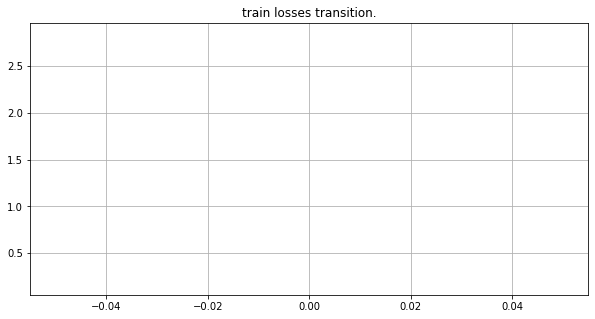

In [70]:
plt.figure(figsize=(10,5))
plt.plot(total_loss, label="loss")
plt.plot(total_acc, label="accuracy")
plt.grid()
plt.title("train losses transition.")
plt.show()

In [72]:
os.makedirs("models", exist_ok=True)
torch.save(net.state_dict(), f"models/detect_{str(config['epochs'])}.pth")